In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
from scipy import stats
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures

# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

In [3]:
fname_id = 'HUV250QUV850t0120-1565corhma_AR-types-djf'
filepath = path_to_out +  fname_id + '.csv'
df = pd.read_csv(filepath)
df

,Unnamed: 0,AR_CAT,EOF_CAT,EOF_CAT1,EOF_CAT2
0,1979-12-01 09:00:00,2,0,0,0
1,1979-12-02 09:00:00,2,0,0,0
2,1979-12-03 09:00:00,0,0,0,0
3,1979-12-04 09:00:00,0,0,0,0
4,1979-12-05 09:00:00,0,0,0,0
...,...,...,...,...,...
3515,2018-02-24 09:00:00,0,0,0,0
3516,2018-02-25 09:00:00,0,0,0,0
3517,2018-02-26 09:00:00,1,0,0,0
3518,2018-02-27 09:00:00,0,0,0,0


In [4]:
df['AR_CAT1'] = 0
df['AR_CAT2'] = 0
idx = (df['AR_CAT'] == 1) 
df.loc[idx, 'AR_CAT1'] = 1
idx = (df['AR_CAT'] == 2) 
df.loc[idx, 'AR_CAT2'] = 1


In [5]:
def nearest(items, pivot):
    '''Find the nearest date in a list compared to a single date'''
    nearest=min(items, key=lambda x: abs(x - pivot))
    timedelta = pivot-nearest
    return timedelta.days

In [7]:
# List of dates that match EOF1 conditions
idx = (df.EOF_CAT1 > 0)
x = df['Unnamed: 0'][idx]

# list of dates that match EOF2 conditions
idx = (df.EOF_CAT2 > 0)
y = df['Unnamed: 0'][idx]

timedel = []
for i in range(len(x)):
    t1 = pd.to_datetime(x.iloc[i])
    t2 = pd.to_datetime(y)
    timedel.append(nearest(items=t2, pivot=t1))

np.asarray(timedel)

array([-59, -49, -70, -69,  -9, -33,   0,   1,   0,   0,  33,  34,  -6,
        -4, 349, 350, 351, 352,  -3,  -2,  -1,   0,   0,   1,   9, -12,
       -11, -10,  -9,   0,   9, -19,   1,   1,   2, -15, -14, -13,   8,
        16, -20,  -9,  -8,   0,   0,   0,   1,   0,   0,   1,  -8,  -1,
         0, -21, -20, -19, -18,   0,   0,   0,   0,   0,   0,  24,  25,
       -63, -29, -28, -20,   6,  10,  39,   0,   1,   2, -36, 288, 289,
       352, 355,  15,  16,   0, -31, -30,   0, -65, -64, -63,  10,  11,
         0,  17, -11, -10,   0,   0,   0,   0,   2,   3,   0,  24,   0,
         0,   0, -12, -11,   1,   0,   1,  -1,   0, -16,   0, -21,   0,
         1,   4,   6,  15,  16,  -1,   0,  11,  12,   0,  -1,   1,   2,
         0,  -1,   0,   0,  -1,  -1,   0,  -7,  -6,  -5,  -4,  -3, 286])

In [8]:
# List of dates that match AR1 conditions
idx = (df.AR_CAT1 > 0)
x2 = df['Unnamed: 0'][idx]

# list of dates that match EOF2 conditions
idx = (df.AR_CAT2 > 0)
y2 = df['Unnamed: 0'][idx]

timedel2 = []
for i in range(len(x2)):
    t1 = pd.to_datetime(x2.iloc[i])
    t2 = pd.to_datetime(y2)
    timedel2.append(nearest(items=t2, pivot=t1))

np.asarray(timedel2)

array([  10,  -14,  -61,  -60,  -11,   -2,   -1,   20,   21,   54,   55,
          3,    4,    5,   50,    7,  -18,   19,    4,    5,    2,    3,
         -9,   -4,    8,    9,    7,   -8,    1,    2,    3,    7,    8,
         16,    8,    9,   -8,    2,    3,   -3,    4,    5,    8,   11,
         12,  -14,  -13,  -10,   -9,   12,   13,   24,   25,   26,  -29,
        -28,  -20,    5,    6,   29,   30,   51,   66,   68,   69,   70,
         71,  -36,  -29,  -28,  -27,  -23,   -3,   -5,    5, -346, -331,
       -330,   -6,   38,   15,   16,  -23,    4,   11,   29,    1,    2,
          9,   10,    6,    3,    4,  -12,  -11,   -9,   -8,    2,    1,
          1,  -16,    1,    2,    1,    4,    7,    8,    9,   10,  -12,
        -11,  -15,  -14,  -24,  -23,    1,  -39,  -38,  -16,  -15,    1,
          1,  -13,  -12,  -11,   10,    6,    7,    4,    6,   15,   16,
        370, -372, -371, -370, -359, -358,  -69,  -49,  -48,    1,    2,
          3,   -2,   -9,   -8,   22,   23,   24,  -

Number of times EOF1 and EOF2 overlap: 40
Number of times AR1 and AR2 overlap: 0


Text(0, 0.5, 'Number of days between modes')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


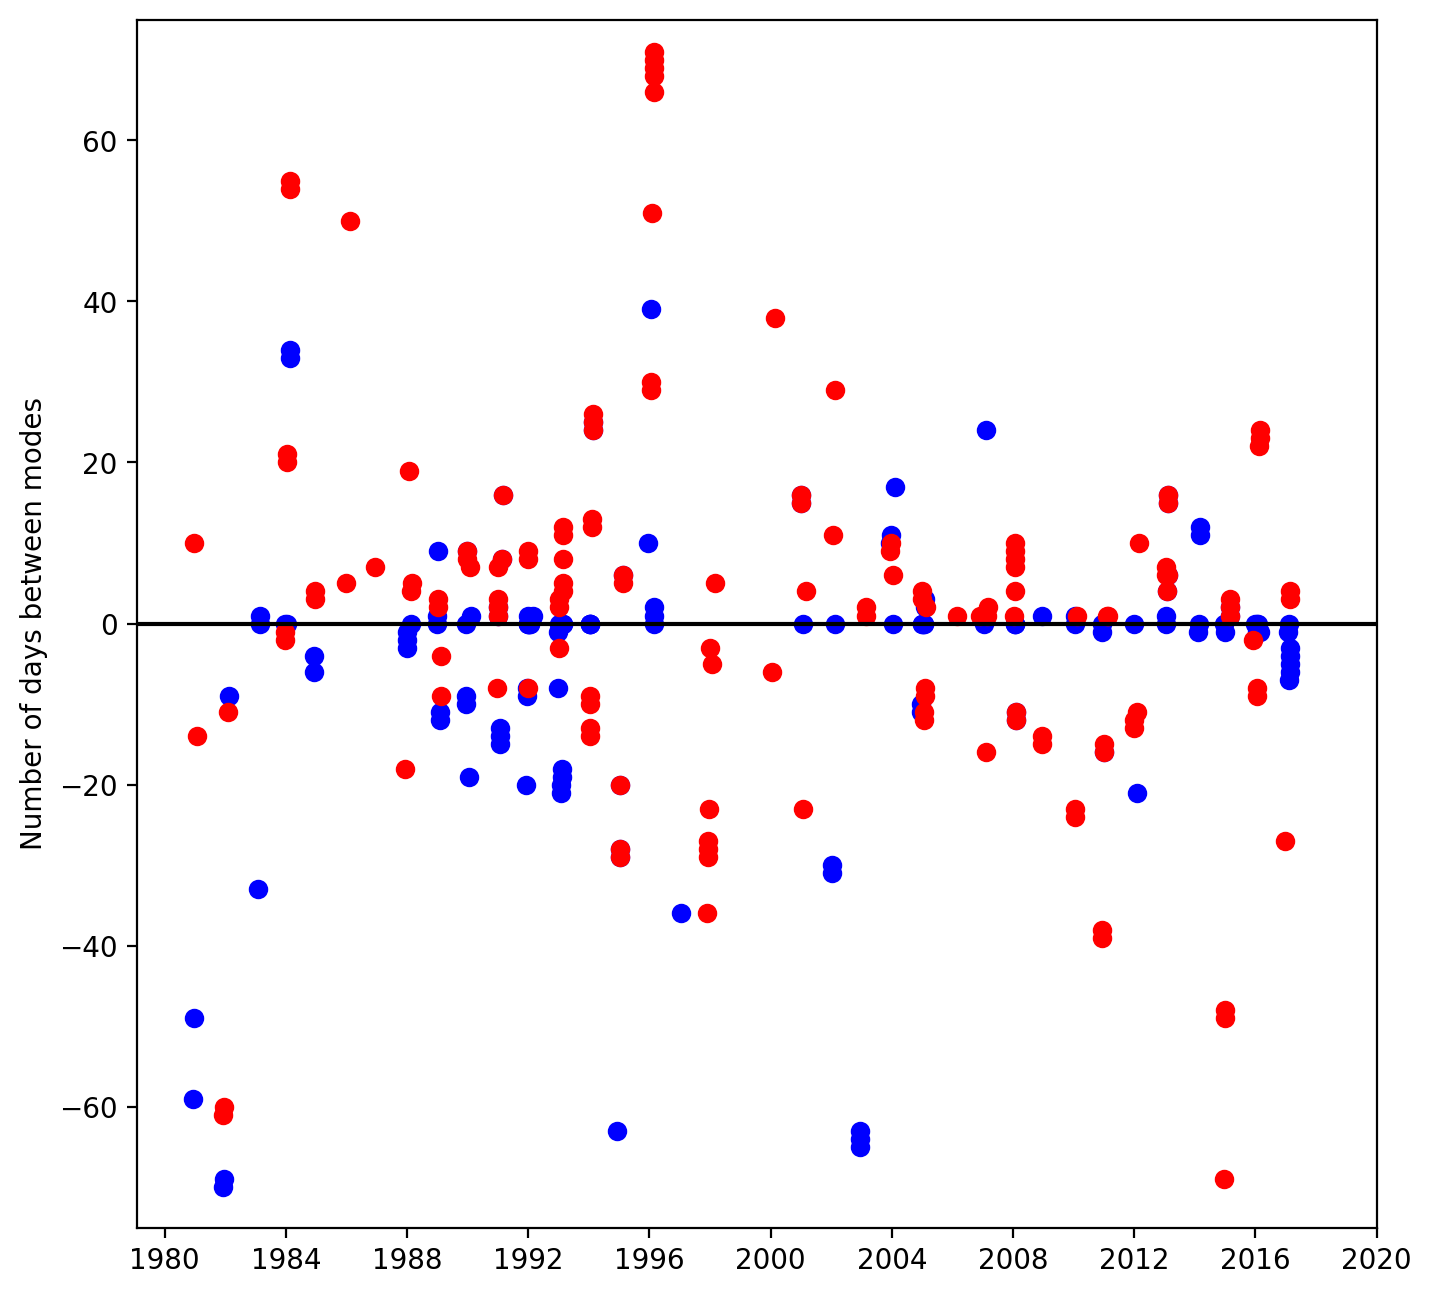

In [9]:
# plot date of list x and number of days to next event as y
fig = plt.figure(figsize=(8, 8))
fig.dpi = 200
fmt = 'png'

x = pd.to_datetime(x)
y = np.asarray(timedel)
print('Number of times EOF1 and EOF2 overlap:', len(y) - np.count_nonzero(y))

x2 = pd.to_datetime(x2)
y2 = np.asarray(timedel2)
print('Number of times AR1 and AR2 overlap:', len(y2) - np.count_nonzero(y2))

ax = plt.subplot(111)
ax.plot(x, y, 'bo')
ax.plot(x2, y2, 'ro')
ax.set_ylim([-75, 75])
ax.axhline(0, color='k')
ax.set_ylabel('Number of days between modes')


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc5befd3350>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc5befd3dd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc5befca310>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc5befda8d0>,
 'fliers': [],
 'means': []}

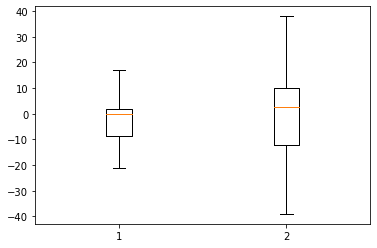

In [10]:
data = [y, y2]
fig1, ax1 = plt.subplots()
ax1.boxplot(data,  showfliers=False)


In [ ]:
df.index = pd.to_datetime(df['Unnamed: 0'])
# # resample to monthly
# df_month = df.resample('M', label='right').sum()
# resample to weekly
df_month = df.resample('W', label='right').sum()
df_month = df_month[df_month.index.month.isin([12, 1, 2])]
df_month

In [ ]:
fname = path_to_figs + 'PC_ts'+ fname_id 
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((20.0,4.0))
fig.dpi = 300
nplots=1

flatui = ["gold","lightcoral"]
          
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    ax.plot(np.arange(len(df_month)), df_month.EOF_CAT1.values, color='r', label='EOF1')
    ax.plot(np.arange(len(df_month)), df_month.EOF_CAT2.values, color='b', label='EOF2')
#     ax.plot(np.arange(len(df_month)), df_month.AR_CAT1.values, color='r', label='AR 1')
#     ax.plot(np.arange(len(df_month)), df_month.AR_CAT2.values, color='b', label='AR 2')
    ax.set_xlim(0,len(df_month))
#     sns.barplot(x=np.arange(len(results)), y='frequency', hue='type', data=results)
    ax.set_ylabel('Total # of AR Days', fontsize=14)
    ax.legend(loc='upper left')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [ ]:
df_month = df_month.drop(columns=['AR_CAT', 'EOF_CAT'])
df_month.loc[:,"date"] = df_month.index
# make a tidy dataframe for seaborn bar plot 
results = pd.melt(df_month, id_vars=['date'], var_name='type', value_name='frequency')
results

In [ ]:
## Select MERRA2 or ERA5
reanalysis = 'era5'

if reanalysis == 'era5':
    start_date = '1979-01-01'
    end_date = '2018-12-31'
    filename = 'ar_catalog_ERAI_fraction_HASIAsubregions.nc'
## if MERRA2
else:
    start_date = '1980-01-01'
    end_date = '2017-12-31'
    filename = 'ar_catalog_fraction_HASIAsubregions.nc'
    
f1 = path_to_data + 'CH1_generated_data/' + filename
ds = xr.open_dataset(f1)
# Set dates
ds = ds.sel(time=slice(start_date, end_date))
## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()

In [ ]:
len(df)

In [ ]:
## time series of AR Days
fig, ax = plt.subplots(figsize=(6,4))
x=np.arange(len(df))
## Use the following syntax to access data via variable/column names
y=df.ar
## Use matplotlib's plot_date function when your x-axis is a datetime series
ax.bar(x, y)

plt.show()

In [ ]:
## import HMA loadings t-mode correlation matrix
filename = path_to_out + 'loadings_HUV250QUV850t0120-1565cor.txt'
col_names = ['PC1', 'PC2', 'PC3', 'PC4']
df1 = pd.read_csv(filename, header=None, names=col_names)
df1



xx = df1.PC1.values
yy = df1.PC2.values

print(np.isnan(xx).any())
print(np.isnan(yy).any())

print(np.isinf(xx).any())
print(np.isinf(yy).any())

r, pval = stats.pearsonr(xx, yy)
print(r, pval)

In [ ]:
df1

In [ ]:
np.std(yy)

In [ ]:
np.mean(yy)

In [ ]:
df1.hist()

In [ ]:
df1.PC1 
std_PC = np.std(df1)
mean_PC = np.mean(df1)
std_PC
idx = (df1['PC1']-mean_PC.PC1 >= std_PC.PC1) | (df1['PC1']-mean_PC.PC1 <= std_PC.PC1*-1)
PC1_sel = df1.PC1.loc[idx]

idx = (df1['PC2']-mean_PC.PC2 >= std_PC.PC2) | (df1['PC2']-mean_PC.PC2 <= std_PC.PC2*-1)
PC2_sel = df1.PC2.loc[idx]

In [ ]:
fig = plt.figure(figsize=(20, 3))
fig.dpi = 200
fmt = 'png'

x = np.arange(len(xx))


ax = plt.subplot(111)
ax.plot(x, xx, 'b-')
ax.plot(PC1_sel.index, PC1_sel.values, 'bo', label='PC1')
ax.plot(x, yy, 'g-')
ax.plot(PC2_sel.index, PC2_sel.values, 'go', label='PC2')
ax.axhline(0, color='k')
ax.set_ylim(-1, 1)
ax.set_xlim(0, 371)
ax.legend()

In [ ]:
filename = path_to_out + 'HUV250QUV850t0120-1565corhma_AR-types-djf.csv'
df = pd.read_csv(filename)
df

In [ ]:
df.EOF_CAT2.sum()

In [ ]:
## time series of AR Days
fig, ax = plt.subplots(figsize=(12,4))
x=df.iloc[:, 0].values
ax.plot_date(x, df.AR_CAT, 'bo')
ax.plot_date(x, df.EOF_CAT, 'ro')

plt.show()

In [ ]:
## time series of AR Days
fig, ax = plt.subplots(figsize=(12,4))
x=np.arange(len(df))
ax.plot(x, df.EOF_CAT1, 'bo')
ax.plot(x, df.EOF_CAT2, 'ro')

plt.show()